In [8]:
%load_ext autoreload
%autoreload 2
import sys
import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from UNet import UNet, UNet_encoder
from ZUNet_v1 import ZUNet_v1, ZUNet_v2
from dataloader import TE_loader
import torch
import nibabel as nib
import ttach as tta

import cv2
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops

import SimpleITK as sitk
sitk.ProcessObject_SetGlobalWarningDisplay(False)

def remove_noise(pred, by="centroid"):
    cleared = clear_border(pred)
    label_img = label(cleared)
    z = pred.shape[2]
    if by == "area":
        areas = [r.area for r in regionprops(label_img)]
        areas.sort()
        if len(areas) > 2:
            for region in regionprops(label_img):
                if region.area < areas[-2]:
                    for coordinates in region.coords:
                        label_img[coordinates[0], coordinates[1]] = 0
    elif by == "centroid":
        rs = regionprops(label_img)
        # if len(rs)>2:
        # Remove if the centroids are not in between 25%~75%
        for r in rs:
            if np.mean(r.coords[:, 0]) <= 128 or np.mean(r.coords[:, 0]) >= 384:
                label_img[r.coords[:, 0], r.coords[:, 1]] = 0
            if np.mean(r.coords[:, 1]) <= 128 or np.mean(r.coords[:, 1]) >= 384:
                label_img[r.coords[:, 0], r.coords[:, 1]] = 0
            if np.mean(r.coords[:, 2])/z <= 0.25 or np.mean(r.coords[:, 2])/z >= 0.75:
                label_img[r.coords[:, 0], r.coords[:, 1]] = 0

    mask = label_img > 0
    mask = mask.astype(np.uint8)
    return mask

# def remove_noise(pred):
#     cleared = clear_border(pred)
#     label_img = label(cleared)
    
#     # if centriods of regions are outside of 100 412 in x,y, exclude
#     rs = regionprops(label_img)
#     if len(rs)>2:
#         for r in rs:
#             if np.mean(r.coords[:,0])<=100 or np.mean(r.coords[:,0])>=412:
#                 label_img[r.coords[0],r.coords[1]] = 0
#             if np.mean(r.coords[:,1])<=100 or np.mean(r.coords[:,1])>=412:
#                 label_img[r.coords[0],r.coords[1]] = 0
#     mask = label_img > 0
#     mask = mask.astype(np.uint8)
#     return mask


def volume_inference_multiC_z(model, volume,threshold=0.5):
    # volume: C x H x W x Z
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    slices = np.zeros((volume.shape[1:]))
    volume = np.flip(volume, axis=-1)
    for i in range(volume.shape[-1]):
        s = volume[:, :, :, i]
        s = s.astype(np.single)
        s = torch.from_numpy(s).unsqueeze(0)
        # s = torch.from_numpy(s).unsqueeze(0).unsqueeze(0)
        z = i / (volume.shape[-1] + 1)
        z = np.floor(z * 10)
        z = torch.tensor(z, dtype=torch.int64)
        pred = model(s.to(DEVICE), z.to(DEVICE))
        pred = torch.sigmoid(pred)
        pred = np.squeeze(pred.cpu().detach())
        pred[pred > threshold] = 1
        pred[pred <= threshold] = 0

        slices[:, :, i] = pred * 255
    slices = np.flip(slices, axis=-1)
    return slices

def run_open(pred_label, kernel=[10,10,10]):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    # kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (100,100))
    open = cv2.morphologyEx(pred_label, cv2.MORPH_OPEN, kernel, iterations=1)
    return open


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
infer_path = "data/ProjSubjList.in"
parameter_path = "/data1/inqlee0704/silicosis/RESULTS/ZUNet_v1_multiC_lung_n64_20211006/ZUNet_v1_multiC_lung.pth"
infer_list = pd.read_csv(infer_path)
DEVICE = "cuda"
model = ZUNet_v1(in_channels=3)
model.load_state_dict(torch.load(parameter_path))
model.to(DEVICE)
model.eval()

test_data = TE_loader(infer_list, multi_c=True)


Loading Data. . . 


In [9]:
# Augmentation
# transforms = tta.Compose([tta.HorizontalFlip(), tta.VerticalFlip()])

print("Inference . . .")
out_dir = 'data/lung_mask/ZUNet_multiC_n64_open10'
os.makedirs(out_dir, exist_ok=True)
pbar = tqdm(enumerate(test_data), total=len(test_data))
for i, x in pbar:
    if i==0:
        continue
    
    pred_label = volume_inference_multiC_z(model, x["image"])
    pred_label = remove_noise(pred_label, by="centroid")
    break
    
    hdr = nib.Nifti1Header()
    pair_img = nib.Nifti1Pair(pred_label, np.eye(4), hdr)
    

    nib.save(
        pair_img,
        f"{out_dir}"
        + str(infer_list.loc[i, "ImgDir"][-9:-7])
        + ".img.gz",
    )

Inference . . .


  0%|          | 0/30 [00:00<?, ?it/s]

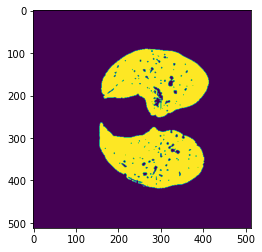

In [10]:
plt.imshow(pred_label[:,:,30])

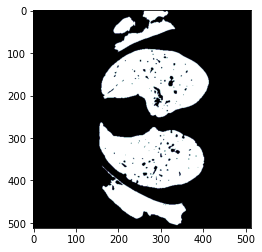

In [31]:
temp = pred_label[:,:,30].copy()
plt.imshow(temp,cmap='bone')

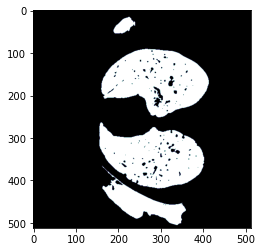

In [32]:
cleared = clear_border(temp)
plt.imshow(cleared,cmap='bone')

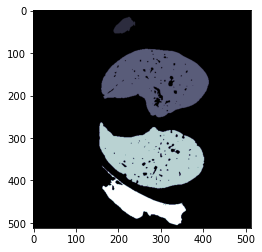

In [33]:
label_img = label(cleared)
plt.imshow(label_img,cmap='bone')

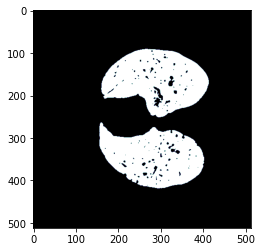

In [59]:
areas = [r.area for r in regionprops(label_img)]
areas.sort()
if len(areas) > 2:
    for region in regionprops(label_img):
        if region.area < areas[-2]:
            for coordinates in region.coords:                
                    label_img[coordinates[0], coordinates[1]] = 0
binary = label_img > 0
binary = binary.astype(np.uint8)
plt.imshow(binary, cmap='bone') 

In [4]:
pred_label.shape

(512, 512, 64)

In [5]:
cleared = clear_border(pred_label)
label_img = label(cleared)
rs = regionprops(label_img)

In [6]:
r = rs[0]

In [7]:
r.coords.shape

(1855876, 3)

In [62]:
# if centriods of regions are outside of 100 412 in x,y, exclude
rs = regionprops(label_img)
if len(rs)>2:
    for r in rs:
        if np.mean(r.coords[:,0])<=100 or np.mean(r.coords[:,0])>=412:
            label_img[r.coords[:,0],r.coords[:,1]] = 0
        if np.mean(r.coords[:,1])<=100 or np.mean(r.coords[:,1])>=412:
            label_img[r.coords[:,0],r.coords[:,1]] = 0
binary = label_img > 0
binary = binary.astype(np.uint8)

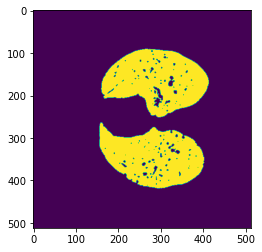

In [63]:
plt.imshow(binary)

In [58]:
r.coords[0]

array([366, 162])

In [57]:
np.mean(r.coords[:,0])

454.3774561713143

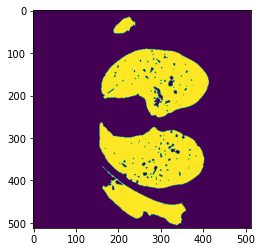

In [55]:
plt.imshow(binary)

In [50]:
r = rs[0]
np.mean(r.coords[:,0])

36.7120067170445

In [44]:
x_mean = np.mean(rs[0].coords[:,0])
y_mean = np.mean(rs[0].coords[:,1])

In [36]:
areas

[1, 1191, 8499, 24473, 25979]

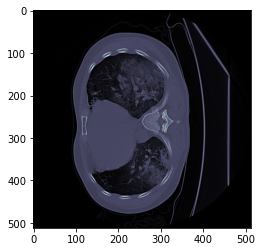

In [16]:
temp = test_data[0]['raw_image'][:,:,30].copy()
plt.imshow(temp,cmap='bone')

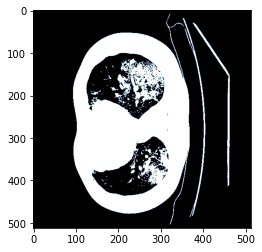

In [17]:
temp[temp>=-400] = 1
temp[temp<-400] = 0
plt.imshow(temp,cmap='bone')

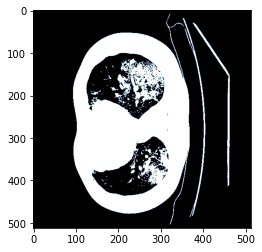

In [18]:
cleared = clear_border(temp)
plt.imshow(cleared,cmap='bone')

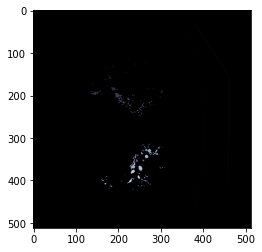

In [20]:
label_img = label(cleared)
plt.imshow(label_img,cmap='bone')

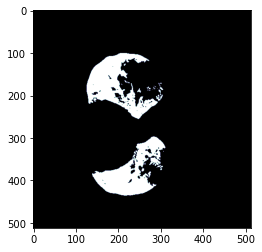

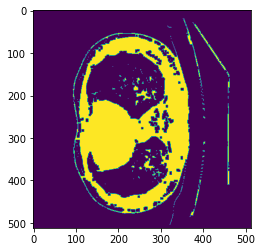

In [29]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
# kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (100,100))
close = cv2.morphologyEx(temp, cv2.MORPH_CLOSE, kernel, iterations=1)
plt.imshow(close)

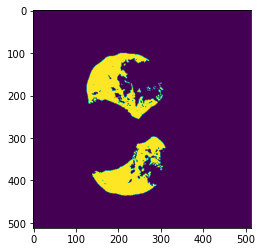

In [14]:
plt.imshow(pred_label[:,:,30])

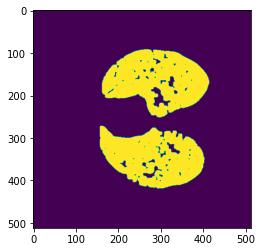

In [68]:
plt.imshow(pred_label[:,:,30])

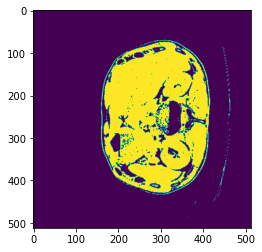

In [39]:
temp = raw_img[:,:,0]
plt.imshow(temp)

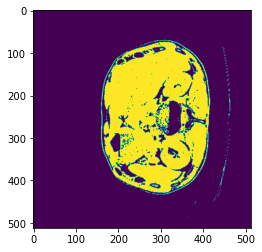

In [40]:
temp[temp<0] = 0
temp[temp>200] = 0
temp[temp!=0] = 1
plt.imshow(temp)

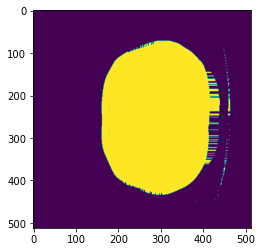

In [43]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (100,100))
# kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (100,100))
close = cv2.morphologyEx(temp, cv2.MORPH_CLOSE, kernel, iterations=1)
plt.imshow(close)

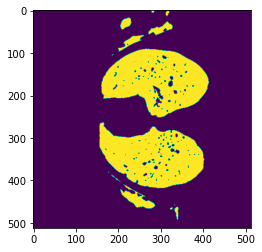

In [32]:
plt.imshow(pred_label[:,:,31])

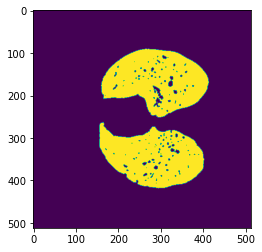

In [33]:
plt.imshow(pred_label[:,:,31]*close)

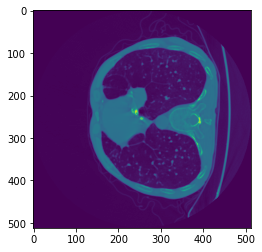

In [133]:
plt.imshow(temp[:,:,20])

In [ ]:
# Post-processing
